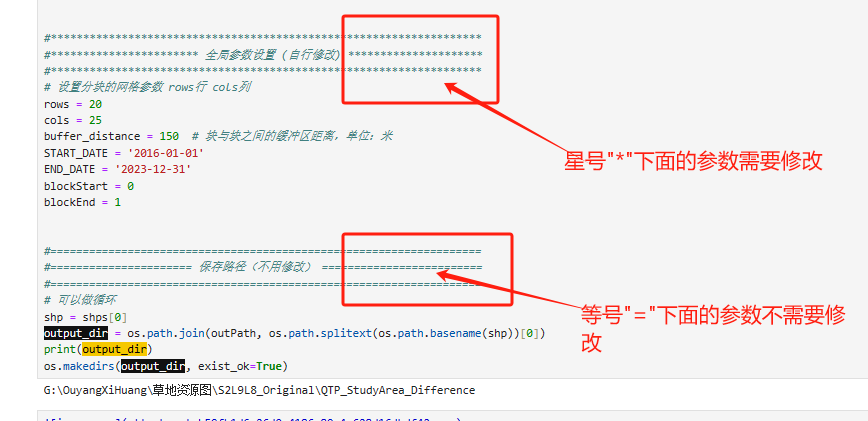

# 初始化

In [44]:
import ee, os
import geemap

# 初始化Earth Engine
geemap.set_proxy(port=1080)     #修改

credential_path = os.path.expanduser("~/.config/earthengine")
if os.path.exists(credential_path):
    for file in os.listdir(credential_path):
        file_path = os.path.join(credential_path, file)
        if os.path.isfile(file_path):
            # os.remove(file_path)
            print(file_path)

ee.Authenticate()
ee.Initialize()

import geedim as gd
gd.Initialize()

Map = geemap.Map()

C:\Users\hqm/.config/earthengine\credentials


# 定义函数

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel-2云掩膜函数
def maskCloudSnowSentinel2(image):
    qa = image.select('QA60')
    cloudProb = image.select('MSK_CLDPRB')
    
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0)
            .And(qa.bitwiseAnd(cirrusBitMask).eq(0)))
    mask = mask.And(cloudProb.lte(20))
    
    return (image.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'QA60'], 
                         ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA'])
            .updateMask(mask)
            .copyProperties(image, ["system:time_start"]))

# Landsat 云掩膜函数
def maskCloudsLandsat(image):
    qa = image.select('QA_PIXEL')
    
    cloudBitMask = 1 << 3
    cirrusBitMask = 1 << 2
    cloudConfidenceBitMask = (1 << 8) | (1 << 9)
    
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0)
            .And(qa.bitwiseAnd(cirrusBitMask).eq(0)))
    mask = mask.And(qa.bitwiseAnd(cloudConfidenceBitMask).lte(1 << 8))
    
    return (image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
                         ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA'])
            .updateMask(mask)
            .copyProperties(image, ["system:time_start"]))


# 辅助函数：Transformation
def convertBandsToInt16(collection, bands, scaleFactor=1):
    def processImage(image):
        selectedBands = image.select(bands)
        convertedBands = selectedBands.multiply(scaleFactor).round().toUint16()
        return image.addBands(convertedBands, None, True)
    
    return collection.map(processImage)
# 定义重采样函数
def resample_to_30m(image):
    return image.reproject(crs='EPSG:4326', scale=10)  
# 对 filledSingleComposites 进行重采样

# 添加年份和日期信息的函数
def addYearDay(image):
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')
    dayOfYear = date.getRelative('day', 'year').add(1)
    return image.set('year', year).set('day_of_year', dayOfYear)
    
# Landsat 8缩放函数
def scaleL8(image):
    opticalBands = (image.select(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])
                    .multiply(0.0000275).add(-0.2).multiply(10000))
    return image.addBands(opticalBands, None, True)

    
def L89_applyCustomBandTransformations(image):
    # 定义转换公式 image原本需要乘一个缩放系数此处直接追加在公式中
    transformations = {
        'Blue': 'Blue*1.0487+47',
        'Green': 'Green*1.0296+17',
        'Red': 'Red*1.0661+13',
        'NIR': 'NIR*0.9804+39',
        'SWIR1': 'SWIR1*1.0326+101',
        'SWIR2': 'SWIR2*1.1046+43'
    }
    
    # 应用转换
    transformedBands = ee.Image.cat([
        image.expression(
            transformations[bandName],
            {
                'Blue': image.select('Blue'),
                'Green': image.select('Green'),
                'Red': image.select('Red'),
                'NIR': image.select('NIR'),
                'SWIR1': image.select('SWIR1'),
                'SWIR2': image.select('SWIR2')
            }
        ).rename(bandName) for bandName in transformations
    ])
    
    return transformedBands

# 函数：添加时间属性
def addTimeAttribute(image):
    dayOfYear = ee.Number(image.get('day_of_year'))
    date = ee.Date.fromYMD(2020, 1, 1).advance(dayOfYear.subtract(1), 'day')
    return image.set('system:time_start', date.millis())
    
    
# 处理10天时间段的函数
# 定义一个函数来处理每10天的影像
def process_10_day_period(day_of_year):
    # Sentinel-2
    s2_filtered = s2.filter(ee.Filter.calendarRange(day_of_year, ee.Number(day_of_year).add(9), 'day_of_year'))
    s2_composite = ee.Algorithms.If(s2_filtered.size().gt(0),
        s2_filtered.median().set('day_of_year', day_of_year).set('empty', False),
        ee.Image().set('day_of_year', day_of_year).set('empty', True))

    # Landsat 8
    l8_filtered = l8.filter(ee.Filter.calendarRange(day_of_year, ee.Number(day_of_year).add(9), 'day_of_year'))

    # Landsat 9
    l9_filtered = l9.filter(ee.Filter.calendarRange(day_of_year, ee.Number(day_of_year).add(9), 'day_of_year'))

    # 合并Landsat 8和9，优先使用Landsat 8
    landsat_composite = ee.Algorithms.If(
        l8_filtered.size().gt(0),
        ee.Algorithms.If(
            l9_filtered.size().gt(0),
            l8_filtered.median().unmask(l9_filtered.median()),
            l8_filtered.median()
        ),
        ee.Algorithms.If(
            l9_filtered.size().gt(0),
            l9_filtered.median(),
            ee.Image().set('empty', True)
        )
    )

    # 合并Sentinel-2和Landsat数据，优先使用Sentinel-2
    combined = ee.Algorithms.If(
        ee.Image(s2_composite).bandNames().length().gt(0),
        ee.Image(s2_composite).unmask(ee.Image(landsat_composite)).updateMask(
            ee.Image(s2_composite).select(0).mask()
        ),
        ee.Image(landsat_composite)
    )

    return ee.Image(combined)

# 单一空缺使用均值插补,创建一个函数来处理每个图像
def fillGapsWithMean(composites):
    def fillGaps(image, list):
        index = list.indexOf(image)
        size = list.size()
        
        prev = ee.Image(ee.Algorithms.If(index.gt(0), 
            ee.Image(list.get(index.subtract(1))), image))
        next = ee.Image(ee.Algorithms.If(index.lt(size.subtract(1)), 
            ee.Image(list.get(index.add(1))), image))
        
        fillValue = prev.add(next).divide(2)
        filled = image.unmask(fillValue)
        
        return filled.set('day_of_year', image.get('day_of_year'))

    compositeList = composites.toList(composites.size())

    filledList = compositeList.map(lambda image: fillGaps(ee.Image(image), compositeList))

    return ee.ImageCollection(filledList)

# 连续多空缺使用线性插补
def linearRegressionInterpolate(imageCollection, bands, n, roi):
    originalCollection = imageCollection
    
    def interpolate(image):
        targetDayOfYear = ee.Number(image.get('day_of_year'))
        
        filteredCollection = originalCollection.filter(
            ee.Filter.And(
                ee.Filter.gte('day_of_year', targetDayOfYear.subtract(10*n+1)),
                ee.Filter.lte('day_of_year', targetDayOfYear.add(10*n+1))
            )).sort('day_of_year')
        
        def prepareRegressionData(img):
            doy = ee.Image.constant(ee.Number(img.get('day_of_year'))).float().rename('doy')
            values = img.select(bands)
            return doy.addBands(values)

        regressionData = filteredCollection.map(prepareRegressionData)
        
        def linearFit(band):
            bandData = regressionData.select(['doy', band])
            return bandData.reduce(ee.Reducer.linearFit()).rename([f'{band}_slope', f'{band}_intercept'])

        linearResults = ee.Image.cat([linearFit(band) for band in bands])
        
        interpolated = (ee.Image(targetDayOfYear).float().rename('doy')
                        .multiply(linearResults.select([f'{band}_slope' for band in bands]))
                        .add(linearResults.select([f'{band}_intercept' for band in bands]))
                        .rename(bands))
        
        # mask = image.select(bands).mask()
        # masknot = image.select(bands).mask().Not()
        # roiMask = ee.Image.constant(1).clip(roi).mask()
        # processedMask = masknot.And(roiMask)
        # finalMask = mask.Or(processedMask)
        
        # filledImage = (image.select(bands).unmask()
        #                .where(processedMask, interpolated.select(bands))
        #                .updateMask(finalMask))
        filledImage = interpolated
        
        result = image.addBands(filledImage, None, True)
        
        return result.clip(roi)

    return imageCollection.map(interpolate)

# 辅助函数：乘以10000并取整
def scaleAndRound(img):
    return img.multiply(10000).round()
    
def createVI(image):
    scaled = image.select(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])
    
    # 辅助函数
    def normalizedDifference(band1, band2):
        return scaled.normalizedDifference([band1, band2])
    
    def scaleAndRound(img):
        return img.multiply(10000).round().uint16()
    
    # NDVI
    ndvi = normalizedDifference('NIR', 'Red')
    ndvi = ndvi.where(ndvi.lt(0), 0).where(ndvi.gt(1), 1)
    ndvi = scaleAndRound(ndvi).rename('NDVI')
    
    # RVI
    rvi = scaled.select('Red').divide(scaled.select('NIR'))
    rvi = rvi.where(rvi.lt(0), 0).where(rvi.gt(6.5535), 6.5535)
    rvi = scaleAndRound(rvi).rename('RVI')
    
    # CRI
    cri = scaled.select('Blue').divide(10000).pow(-1).subtract(scaled.select('Green').divide(10000).pow(-1))
    cri = cri.where(cri.lt(0), 0).where(cri.gt(6.5535), 6.5535)
    cri = scaleAndRound(cri).rename('CRI')
    
    
    # RGR
    rgr = scaled.select('Red').divide(scaled.select('Green'))
    rgr = rgr.where(rgr.lt(0), 0).where(rgr.gt(6.5535), 6.5535)
    rgr = scaleAndRound(rgr).rename('RGR')
    
    # NDII
    ndii = normalizedDifference('NIR', 'SWIR1').add(1)
    ndii = ndii.where(ndii.lt(0), 0).where(ndii.gt(2), 2)
    ndii = scaleAndRound(ndii).rename('NDII')
    
    # SATVI
    satvi = scaled.expression(
        '((SWIR1 - RED) / (SWIR1 + RED + 5000)) * (1 + 0.5) - (SWIR2 / 20000)',
        {'SWIR1': scaled.select('SWIR1'), 'RED': scaled.select('Red'), 'SWIR2': scaled.select('SWIR2')}
    )
    satvi = satvi.where(satvi.lt(0), 0).where(satvi.gt(6.5535), 6.5535)
    satvi = scaleAndRound(satvi).rename('SATVI')
    
    # CAI
    cai = scaled.select('SWIR2').divide(scaled.select('SWIR1'))
    cai = cai.where(cai.lt(0), 0).where(cai.gt(6.5535), 6.5535)
    cai = scaleAndRound(cai).rename('CAI')
    
    # SAVI
    savi = scaled.expression(
        '(((NIR - RED) * (1 + 0.5)) / (NIR + RED + 5000)) + 1',
        {'NIR': scaled.select('NIR'), 'RED': scaled.select('Red')}
    )
    savi = savi.where(savi.lt(0), 0).where(savi.gt(2), 2)
    savi = scaleAndRound(savi).rename('SAVI')
    
    # VARI
    vari = scaled.expression(
        '((GREEN - RED) / (GREEN + RED - BLUE)) + 1',
        {'GREEN': scaled.select('Green'), 'RED': scaled.select('Red'), 'BLUE': scaled.select('Blue')}
    )
    vari = vari.where(vari.lt(0), 0).where(vari.gt(2), 2)
    vari = scaleAndRound(vari).rename('VARI')
    
    return image.addBands([ndvi, rvi, cri, rgr, ndii, satvi, cai, savi, vari])

def replace_negatives_with_window_minimum(image_collection, window_size=3, bands=None):
    # 确保窗口大小是奇数
    if window_size % 2 == 0:
        window_size += 1
    
    # 如果没有指定波段，处理所有波段
    if bands is None:
        bands = ee.Image(image_collection.first()).bandNames()
    elif isinstance(bands, str):
        bands = [bands]
    
    collection = image_collection.sort('system:time_start')
    image_list = collection.toList(collection.size())
    def process_image(index):
        current_image = ee.Image(image_list.get(index))
        half_window = (window_size - 1) // 2
        start_index = ee.Number(index).subtract(half_window).max(0)
        end_index = ee.Number(index).add(half_window).min(collection.size().subtract(1))
        window_images = image_list.slice(start_index, end_index.add(1))
        
        min_values = ee.ImageCollection.fromImages(window_images).select(bands).map(
            lambda img: img.updateMask(img.gte(0))
        ).min()
        mask = current_image.select(bands).lt(0)
        result = current_image.select(bands).where(mask, min_values)
        return current_image.addBands(result, None, True)
    processed_list = ee.List.sequence(0, collection.size().subtract(1)).map(process_image)
    return ee.ImageCollection(processed_list)

def download_image_collection(collection, block_roi, out_dir, assetid = 'projects/ee-xihuangrsvp/assets/QiangTang'):
    # 获取ImageCollection中的所有影像
    images = collection.toList(collection.size())

    # 遍历所有影像并下载
    size = 37
    for i in range(size):
        image = ee.Image(images.get(i))
        
        # 定义影像的文件路径
        outname = assetid+r'/'+out_dir.split(os.sep)[-1]+r"_Season"+str(i+1)
        # file_path = os.path.join(out_dir, out_dir.split(os.sep)[-1]+r"_直接下载_Season"+str(i)+r'.tif')
                               
        # Export Data
        try:
            geemap.ee_export_image_to_asset(image,
                                            description=outname.split('/')[-1],
                                            assetId=outname, #projects/ee-xihuangrsvp/assets/QiangTang  r'projects/ee-igsnrr2024/assets/'+outname
                                            region=block_roi,
                                            crs='epsg:4326',
                                            scale=10)
            print(f"Successfully Asset image {i+1}/{size}：{outname}")
        except Exception as e:
            print(f"========>>>>>>>> Error Asset image {i+1}/{size}: {str(e)}")
            break
            

def split_roi_with_buffer_and_shp(roi, rows, cols, buffer_size, shp_path=None):
    # 获取 roi 的边界坐标
    coords = roi.bounds().coordinates().get(0).getInfo()
    lon_min, lat_min = coords[0]
    lon_max, lat_max = coords[2]
    
    # 计算每个小块的宽度和高度
    width = (lon_max - lon_min) / cols
    height = (lat_max - lat_min) / rows
    
    # 创建小块列表
    grid = []
    for i in range(rows):
        for j in range(cols):
            lon_left = lon_min + j * width
            lon_right = lon_left + width
            lat_bottom = lat_min + i * height
            lat_top = lat_bottom + height
            
            # 创建小块几何
            cell = ee.Geometry.Rectangle([lon_left, lat_bottom, lon_right, lat_top])
            
            # 添加缓冲区
            buffered_cell = cell.buffer(buffer_size)
            grid.append(ee.Feature(buffered_cell))
    
    # 将grid转换为FeatureCollection
    grid_fc = ee.FeatureCollection(grid)
    
    # 如果提供了shp路径，使用它来筛选grid
    if shp_path:
        # 将shp文件转换为Earth Engine对象
        shp_ee = geemap.shp_to_ee(shp_path)
        
        # 使用ee.Filter.intersects()筛选grid
        filtered_grid = grid_fc.filter(ee.Filter.intersects('.geo', shp_ee.geometry()))
        
        return filtered_grid
    else:
        return grid_fc


def sg_images(images: ee.ImageCollection, window_size: int, order: int, deriv=0):
    half_window = window_size // 2
    order_range = ee.List.sequence(0, order)
    k_range = ee.List.sequence(-half_window, half_window)
    b = ee.Array(k_range.map(lambda k: order_range.map(lambda o: ee.Number(k).pow(o))))
    m_pi = ee.Array(b.matrixPseudoInverse())
    impulse_response = (m_pi.slice(**{'axis': 0, 'start': deriv, 'end': deriv + 1})).project([1]).toList()
    
    count = images.size()
    y = images.toList(count)
    y0 = y.get(0)
    first_filling = y.slice(1, half_window + 1).reverse().map(
        lambda img: ee.Image(img).subtract(y0).abs().multiply(-1).add(y0))
    y_end = y.get(-1)
    last_filling = y.slice(-half_window - 1, -1).reverse().map(
        lambda img: ee.Image(img).subtract(y_end).abs().add(y_end))
    y_ext = ee.List(first_filling.cat(y).cat(last_filling))
    run_length = ee.List.sequence(0, y_ext.length().subtract(window_size))
    smooth = run_length.map(
        lambda i: 
        ee.ImageCollection(ee.List.sequence(0, window_size-1).map(
            lambda j: 
            ee.Image(y_ext.get(ee.Number(i).add(j))).multiply(ee.Number(impulse_response.get(j))).toFloat()
        )).sum().copyProperties(y.get(i), ["system:time_start",'system:id'])
    )
    return ee.ImageCollection(smooth)


# 参数设定

In [51]:
# =================================================== 设置输出路径  ===================================================
import os
from pypinyin import pinyin, lazy_pinyin, style


#*******************************************************************
#************************ 保存设置 (必须修改) ***********************
#*******************************************************************
# 输出路径
outPath = r"F:\work\地理所\地上生物量\输出\2021"    #输出本地路径
# 研究区本地shp文件路径
shps = [r"F:\work\地理所\地上生物量\研究区\roi.shp"  ]     #研究区
# GEE Asset ID (见下图)
myAssetID = r'projects/ee-qiumenghu88/assets/AGB' #r'projects/ee-xihuangrsvp/assets/QiangTang'  #


#*******************************************************************
#*********************** 全局参数设置 (自行修改) *********************
#*******************************************************************
# 设置分块的网格参数 rows行 cols列
rows = 1
cols = 1
buffer_distance = 150  # 块与块之间的缓冲区距离，单位：米
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

# 【【【【【【以下是任务分配】】】】】】
# Ouyang Xihuang：0-200
# Hu Xiao：200-400
# Ming Ru：400-500
blockStart = 0   # 开始的块(一共是500块，大家改成各自的开始的块)  
blockEnd = 1     # 结束的块(一共是500块，大家改成各自的结束的块)


#===================================================================
#====================== 保存路径（不用修改） =========================
#===================================================================
# 可以做循环
shp = shps[0]
output_dir = os.path.join(outPath, os.path.splitext(os.path.basename(shp))[0])
print(output_dir)
os.makedirs(output_dir, exist_ok=True)

F:\work\地理所\地上生物量\输出\2021\roi


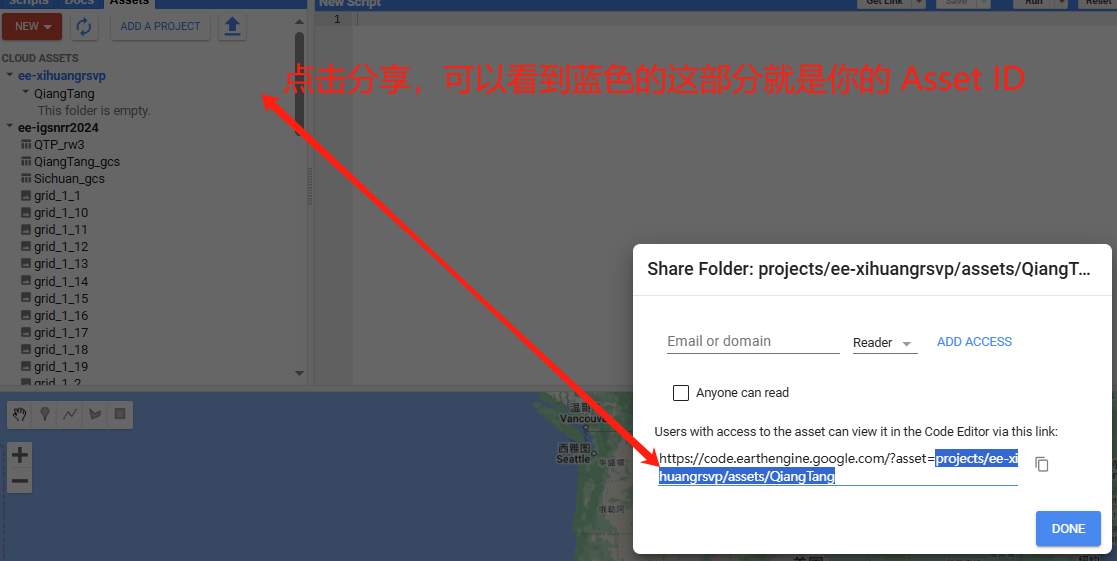

# 开始计算

In [52]:
# ============================================================================================
# ====================================  研究区分块   ==========================================
# ============================================================================================
# 读取研究区域
study_area = geemap.shp_to_ee(shp)
roi = study_area.geometry().bounds()

# 分块
grids = split_roi_with_buffer_and_shp(roi, rows, cols, buffer_distance, shp)
# 获取所有要素
filtered_grid = grids.getInfo()['features']


In [53]:
Map = geemap.Map()

# 使用示例:
plotpoint = ee.Geometry.Point([98.20243976362, 25.97933816879937])
plotbands = ['NDVI', 'RVI', 'SATVI']

# ============================================================================================
# ==============================  开始处理（后面的不用修改）   =================================
# ============================================================================================
# 处理每个网格
for index, feature in list(enumerate(filtered_grid))[blockStart:blockEnd]:
    print(f'Processing grid {index + 1}/{rows*cols}')
    # 将每个要素转换为ee.Feature
    ee_feature = ee.Feature(ee.Geometry.Polygon(feature['geometry']['coordinates']))
    grid = ee_feature.geometry()

    # 获取卫星数据
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(grid)
          .filterDate(START_DATE, END_DATE)
          .map(maskCloudSnowSentinel2)
          .map(addYearDay))
    
    l9 = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
          .filterBounds(grid)
          .filterDate(START_DATE, END_DATE)
          .map(maskCloudsLandsat)
          .map(addYearDay)
          .map(scaleL8))
    
    l8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
          .filterBounds(grid)
          .filterDate(START_DATE, END_DATE)
          .map(maskCloudsLandsat)
          .map(addYearDay)
          .map(scaleL8))

    # 定义10天间隔的日期列表
    days_of_year = ee.List.sequence(1,365, 10)
    
    # 应用函数到每个10天周期
    composites = ee.ImageCollection(days_of_year.map(process_10_day_period))

    # 单一年份缺失使用前后均值填补
    filledSingleComposites = fillGapsWithMean(composites).map(addTimeAttribute).map(resample_to_30m)
    
    # 连续多年缺失使用线性插补填补
    bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
    n = 5  # 使用前后4个图像进行插值
    filledCollection = linearRegressionInterpolate(filledSingleComposites, bands, n, grid).map(addTimeAttribute)
    
    # 计算植被指数
    viCollection = filledCollection.map(createVI)

    # SG滤波平滑处理
    windows = 9  # 在每端添加((windows-1)/2)个图像
    order = 3    # 设置多项式阶数
    bandNames = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA', 'NDVI', "RVI", "CRI", "RGR", "NDII", "SATVI", "CAI", "SAVI", "VARI"]
    extendCollection = viCollection.select(bandNames)
    sgFilteredComposites = sg_images(extendCollection, windows, order)
    
    sgFilteredComposites = replace_negatives_with_window_minimum(sgFilteredComposites, ((windows-1)/2))
    OutComposites = convertBandsToInt16(sgFilteredComposites, bandNames, 1).map(addYearDay)

#     Map.addLayer(grid, {'color': 'blue'}, 'Grid'+str(index))
#     Map.centerObject(grid, 10)

#     # # 设置输出路径
#     grid_output_dir = os.path.join(output_dir, f'grid{index + 1}')
#     download_image_collection(OutComposites, grid, grid_output_dir, assetid = myAssetID)


# print('所有网格处理完成')
# # 设置地图中心和缩放级别
#Map

Processing grid 1/1


In [54]:
# --------结果输出为csv-------------------------------------------------------
shp_path = r"F:\work\地理所\地上生物量\采样点数据\points\Lai.shp"
points_fc = geemap.shp_to_ee(shp_path)  # 这是一个 ee.FeatureCollection
def add_ptid(i):
    # i 是序号特性；这里给每个 feature 设置 PT_00001 这种 ID
    return ee.String('PT_').cat(ee.Number(i).format('%05d'))

indexed = points_fc.toList(points_fc.size())
def with_id(i):
    f = ee.Feature(indexed.get(i))
    return f.set('pt_id', add_ptid(i))

points_fc = ee.FeatureCollection(ee.List.sequence(0, points_fc.size().subtract(1)).map(with_id))

# （可选）给点写入经纬度两列，方便 CSV 使用
def add_lonlat(f):
    coords = f.geometry().coordinates()
    return f.set({'lon': coords.get(0), 'lat': coords.get(1)})
points_fc = points_fc.map(add_lonlat)

# 2) 从 OutComposites 自动获取所有波段
first_img = ee.Image(OutComposites.first())
all_bands = first_img.bandNames()
ic_for_sampling = OutComposites.select(all_bands)

# 3) 给每景影像打上日期属性
def attach_date(img):
    return img.set({
        'date_str': img.date().format('YYYY-MM-dd'),
        'millis': img.date().millis()
    })
ic_for_sampling = ic_for_sampling.map(attach_date)

# 4) 对每景在所有点上采样，并携带日期
def sample_one_image(img):
    samples = img.sampleRegions(
        collection=points_fc,
        scale=10,
        geometries=False  # 已经有 lon/lat 字段了，这里就不导出几何
    )
    return samples.map(lambda f: f.set({'date_str': img.get('date_str'),
                                        'millis': img.get('millis')}))

samples_all = ic_for_sampling.map(sample_one_image).flatten()

# 5) 导出 CSV 到 Google Drive
task = ee.batch.Export.table.toDrive(
    collection=samples_all,
    description='points_timeseries_all_bands2021',
    fileNamePrefix='points_timeseries_all_bands2021',
    fileFormat='CSV'
)
task.start()
print('Task started: points_timeseries_all_bands')



Task started: points_timeseries_all_bands


# 等待GEE中的Asset显示后，即可同步下载到本地（不必等全部显示，显示一部分即可，节省时间）

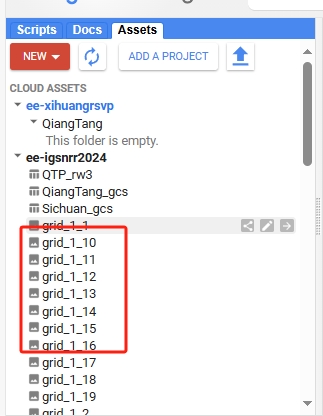

In [ ]:
import ee
import geedim as gd
import os

# 初始化 Earth Engine
# ee.Initialize()
myAssetID = r'projects/ee-qiumenghu88/assets/2023'
outPath = r"F:\work\地理所\地上生物量\输出\2023"
# ********************************************************************************************
# ***************************************  参数设置   *****************************************
# ********************************************************************************************
gridStart =0  # 1     # 从第几块开始 (起始数值为0，不是1)
gridEnd = 1   #2       # 到第几块结束
seasonStart = 0   # 从第几个季节开始 (起始数值为0，不是1)
seasonEnd = 37   #2     # 到第几个季节结束 (应当为37，才为完整的季节动态)


# ============================================================================================
# ===============================  开始下载（后面的不用修改）   ================================
# ============================================================================================
# 定义要下载的 Asset 列表
asset_list = [myAssetID+'/grid'+ str(index + 1) +r"_Season"+str(si+1) for index in range(gridStart, gridEnd) for si in range(seasonStart,seasonEnd,1)]

# 定义输出文件夹
os.makedirs(output_dir, exist_ok=True)

# 遍历 Asset 列表并下载
for asset_id in asset_list:
    try:
        # 加载 Asset
        ee_asset = ee.Image(asset_id)
        
        # 转换为 geedim 对象
        gd_image = gd.MaskedImage(ee_asset)
        
        # 生成输出文件名
        grid_output_dir = output_dir + os.sep +asset_id.split('/')[-2]
        os.makedirs(grid_output_dir, exist_ok=True)
        output_filename = os.path.join(grid_output_dir, f"{asset_id.split('/')[-1]}.tif")
        
        print(f"Downloading {asset_id}...{output_filename}")
        
        # 下载图像
        gd_image.download(
            filename=output_filename,
            # region=roi,
            scale=30,
            dtype='uint16',
            num_threads = 4,
            # max_tile_size = 1000,
            overwrite = False
        )
        
        print(f"Successfully downloaded {asset_id}")
        
    except Exception as e:
        print(f"====>>>> Error downloading {asset_id}: {str(e)}")

print("Download process completed.")


In [ ]:
# def delete_asset_folder(delete_path):
#     # 指定要删除的文件夹路径
#     folder_path = delete_path

#     # 获取该文件夹下的所有资产
# ##     assets = ee.data.getList({'id': folder_path})
# #assets =[r'projects/ee-qiumenghu88/assets/AGB']
# assets = [r'projects/ee-qiumenghu88/assets/AGB']
# assets = ee.data.getList({'id': folder_path})

# # for asset_id in assets:
# #     ee.data.deleteAsset(asset_id)
# #     print(f"Deleted asset: {asset_id}")
# # # 遍历资产列表并删除每个资产
# for asset in assets:
#     asset_id = asset['id']
#     ee.data.deleteAsset(asset_id)
#     print(f"Deleted asset: {asset_id}")
def delete_asset_folder(delete_path):
    # 获取文件夹下的所有资产
    assets = ee.data.getList({'id': delete_path})

    for asset in assets:
        asset_id = asset['id']
        # 如果是文件夹，递归调用
        if asset['type'] == 'FOLDER':
            delete_asset_folder(asset_id)
        else:
            # 删除单个资产
            ee.data.deleteAsset(asset_id)
            print(f"Deleted asset: {asset_id}")

    # 删除空文件夹本身
    ee.data.deleteAsset(delete_path)
    print(f"Deleted folder: {delete_path}")


# 示例调用
delete_asset_folder('projects/ee-qiumenghu88/assets/AGB')